# Spacially optmized dtypes

In [2]:
# Setup

# Libraries
from ucimlrepo import fetch_ucirepo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Fetch the dataset from UCI repository
UCI: pd.DataFrame = fetch_ucirepo(id=144).data.original.rename(columns={'class': 'Target'})

# Original dtypes and memory usage
DTYPES_ORIGINAL: pd.DataFrame = UCI.dtypes.to_frame(name='before')
MEMORY_ORIGINAL:        float = UCI.memory_usage().sum() / 1024


## 1. Categorical features
> By using `categorical` instead of `object` - which<br>
 is infered by pandas when fetching from the UCI repo - we<br>
 can optmize memory usage by up to ~50%

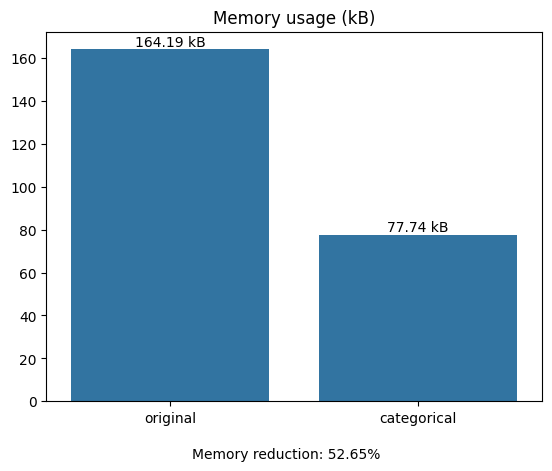

In [2]:
# 1. Change dtypes from 'object' to 'category'
DF_CAT: pd.DataFrame = UCI.copy()
DF_CAT[DF_CAT.select_dtypes('object').columns] = DF_CAT.select_dtypes('object').astype('category')

    # Updated memory usage
MEMORY_CAT: float = DF_CAT.memory_usage().sum() / 1024

# 1.1 Visualize the memory usage
barplot = sns.barplot(x=['original', 'categorical'], y=[MEMORY_ORIGINAL, MEMORY_CAT])

    # Annotate the bars
for p in barplot.patches:
    barplot.annotate(
        f'{p.get_height():.2f} kB', 
        (p.get_x() + p.get_width() / 2., 
        p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 5), 
        textcoords='offset points'
    )

    # Add text at the bottom of the plot

plt.figtext(0.5, 0, f'Memory reduction: {(1 - MEMORY_CAT / MEMORY_ORIGINAL) * 100:.2f}%', ha='center', va='center', fontsize=10)
plt.title('Memory usage (kB)')

plt.show()

## 2. Binaries
> The author chose (1...2) instead of (0...1) for the target value, attributes 19 and 20 have strings instead of binary values, thus we will:
1. Replace with (False...True) 
    - Target [1: True, 2: False](/Users/felipecampelo/dev/projects/german-credit/info/additional-variable-information.md);
    - Att19 [A191: False, A192: True]
    - Att20 [A201: True, A202: False]

2. Convert to `bool`;

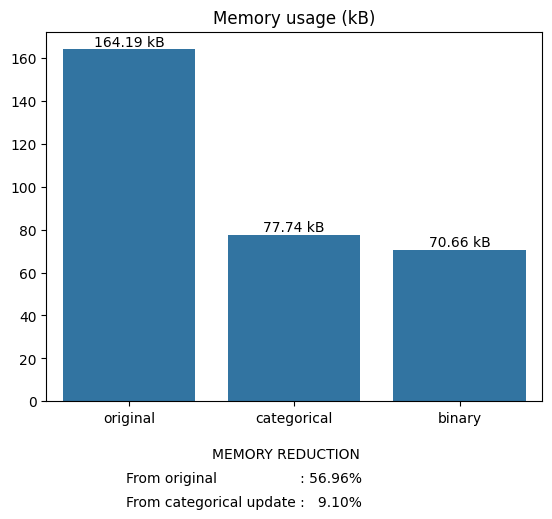

In [3]:
# 2. Preprocess binary columns ----------------------------------------------
DF_BIN: pd.DataFrame = DF_CAT.copy()

## Replace with booleans
DF_BIN['Target']      = DF_BIN['Target'].map(lambda x: x == 1)
DF_BIN['Attribute19'] = DF_BIN['Attribute19'].map(lambda x: x == 'A192')
DF_BIN['Attribute20'] = DF_BIN['Attribute20'].map(lambda x: x == 'A201')

## Convert to bool dtype
DF_BIN[['Target', 'Attribute19', 'Attribute20']] = DF_BIN[['Target', 'Attribute19', 'Attribute20']].astype('bool')

## Updated memory usage
MEMORY_BIN = DF_BIN.memory_usage().sum() / 1024
# dtypes_bin = df_bin.dtypes.to_frame(name='binary') # unused variable

# 2.1 Visualize the memory usage after binary conversion --------------------
barplot = sns.barplot({'original': MEMORY_ORIGINAL, 'categorical': MEMORY_CAT, 'binary': MEMORY_BIN})

## Annotate the bars
for p in barplot.patches:
    barplot.annotate(
        f'{p.get_height():.2f} kB', 
        (p.get_x() + p.get_width() / 2., 
        p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 5), 
        textcoords='offset points'
    )

## Text and title
plt.figtext(0.5, 0, 'MEMORY REDUCTION', ha='center', va='center', fontsize=10)
plt.figtext(0.25, -0.05, f'From original                   : {(1 - MEMORY_BIN / MEMORY_ORIGINAL) * 100:.2f}%', ha='left', va='center', fontsize=10)
plt.figtext(0.25, -0.1, f'From categorical update :   {(1 - MEMORY_BIN / MEMORY_CAT) * 100:.2f}%', ha='left', va='center', fontsize=10)
plt.title('Memory usage (kB)')

plt.show()

## 3. Our final Dtypes

In [4]:
# Final dtypes
pd.concat([
    DTYPES_ORIGINAL,
    DF_CAT.dtypes.to_frame('Category'),
    DF_BIN.dtypes.to_frame('Binary')
    ], 
    axis=1
)

,before,Category,Binary
Attribute1,object,category,category
Attribute2,int64,int64,int64
Attribute3,object,category,category
Attribute4,object,category,category
Attribute5,int64,int64,int64
Attribute6,object,category,category
Attribute7,object,category,category
Attribute8,int64,int64,int64
Attribute9,object,category,category
Attribute10,object,category,category


## 4. Dtype Optmization in a script
> Using the `NBImporter` library we can import the following function as utility

In [13]:
%%writefile ../../utils/dtypes.py
import pandas as pd

def optimization(df: pd.DataFrame) -> pd.DataFrame:
    """
    optimize memory usage by:
    1. converting object Features to category 
    2. Target to bool

    @return: DataFrame with optimized memory usage
    """

    copy: pd.DataFrame = df.copy()

    # 1. Objects to category ---------------------------------------------------------------------
    copy[copy.select_dtypes('object').columns] = copy.select_dtypes('object').astype('category')

    # 2. Booleans --------------------------------------------------------------------------------

    ## Rename 'class' to 'Target'. class is a reserved keyword.
    copy = copy.rename(columns={'class': 'Target'})

    ## Replace with booleans
    copy['Target']      = copy['Target'].map(lambda x: x == 1)
    copy['Attribute19'] = copy['Attribute19'].map(lambda x: x == 'A192')
    copy['Attribute20'] = copy['Attribute20'].map(lambda x: x == 'A201')

    ## Convert dtype to bool
    copy[['Target', 'Attribute19', 'Attribute20']] = copy[['Target', 'Attribute19', 'Attribute20']].astype('bool')

    return copy


Writing ../../utils/dtypes.py


## How a 56% reduction in spatial complexity can help us?